# A Python Implementation of an Html Parser

The following parser was developed as a requirement for applying in the MSc in Information Studies programme at the University of Amsterdam.

The goal was to parse a given collection of articles and plot its Word Count Distribution.

It is developed using only python packages and not 3rd-party ones.  
The parser implements [HTMLParser](https://docs.python.org/2/library/htmlparser.html).
[Counter](https://pypi.org/project/Counter/1.0.0/) package is used for counting words, [string](https://docs.python.org/3/library/string.html) for string manipulation & [matplotlib](https://matplotlib.org/index.html) for creating the histogram.

Since we are interested in counting the words of each article, I ignored all information contained in headlines, subtitles and graphics and only counted the words in the actual article's text. Basic data preparation is performed by cleaning unneeded tags, transforming to lowercase and removing punctuation.

The Document Term Matrix is implemented using a Dictionary (Python's implementation of Hash Tables) with word names as keys and lists of lists as values. A list of arrays or tuples could also be used here.  
More details can be found in the code's comments.

## Part 1 - Implementation of Parser

In [1]:
from html.parser import HTMLParser
from collections import Counter
import string
import matplotlib.pyplot as plt

In [2]:
class MyHTMLParser(HTMLParser):
    dtm = None
    currentDocId = None
    currentTag = None

    def __init__(self):
        super().__init__()
        # Initialize the properties.
        self.currentDocId = 0
        self.currentTag = ""
        self.dtm = {}

    def handle_starttag(self, tag, attrs):
        # Increment the current doc id whenever we encounter a new document.
        if tag == "doc":
            self.currentDocId += 1
        self.currentTag = tag

    def handle_endtag(self, tag):
        # Clear the current tag.
        self.currentTag = ""

    def handle_data(self, data):
        # We are only interested in the words contained in the article's actual text. 
        # Other information like headings, authors, nr of words are not useful for word count.
        if self.currentTag == 'text':
            # Translates a string removing punctuation.
            punctuation_translator = str.maketrans('', '', string.punctuation)
            # Remove the punctuation and transform the words to lowercase.
            cleaned = data.translate(punctuation_translator).lower()
            # Count the words in the text using python's Counter.
            wordcount = Counter(cleaned.split())
            # For each word, append the documentId, wordcount pair into the dictionary.
            for key in wordcount:
                # Create the list if we encountered a new word.
                if key not in self.dtm:
                    self.dtm[key] = []
                self.dtm[key].append([self.currentDocId, wordcount[key]])

    def error(self, message):
        print("Error while parsing file.")

In [3]:
parser = MyHTMLParser()
with open('collection.txt') as f:
    # We remove the <p> tags as they serve no purpose in our analysis.
    # They are there just to format HTML.
    parser.feed(f.read().replace('<p>', '').replace('</p>', ''))

# Show samples of the created document term matrix
print("Appearances of the word 'the': ", parser.dtm['the'])
print("Appearances of the word 'as': ", parser.dtm['as'])

Appearances of the word 'the':  [[1, 94], [2, 12], [3, 67]]
Appearances of the word 'as':  [[1, 7], [2, 1], [3, 5]]


## Part 2 - Word Count Distribution

Text(0.5,1,'Word Frequency Distribution (Count <= 10)')

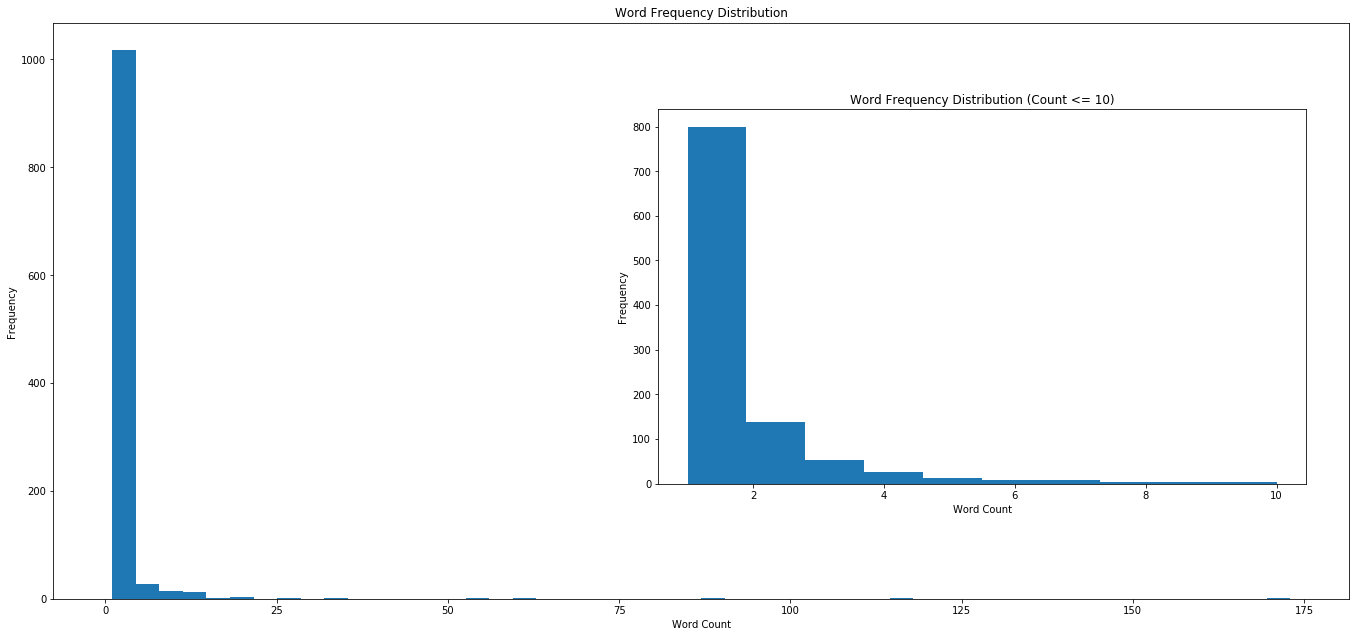

In [4]:
# Count the total frequency(spanning across all documents) of each word.
wordCounts = []
for word in parser.dtm:
    wordfreq = 0
    for docnr in range(len( parser.dtm[word] )):
        wordfreq += parser.dtm[word][docnr][1]
    wordCounts.append(wordfreq)

# Create a new Figure
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 3, 2])
axes.hist(wordCounts, 50)
axes.set_xlabel('Word Count')
axes.set_ylabel('Frequency')
axes.set_title('Word Frequency Distribution')

axes2 = fig.add_axes([1.5, 0.5, 1.5, 1.3])
axes2.hist([x for x in wordCounts if x <= 10])
axes2.set_xlabel('Word Count')
axes2.set_ylabel('Frequency')
axes2.set_title('Word Frequency Distribution (Count <= 10)')

The above figure shows a right-skewed frequency distribution.  
We can see that there are more than 1000 words that occur only once.  
Most of the words occur 1 or 2 times in the documents.  
Common words(or stop words) like 'the', 'of', 'a' occur multiple times more frequent than the rest.

Although the sample in this case is small, we can already see Zipf's Law formulating. If we take a look at the x axis, we can see that the more frequent a word is, the more its distance increases from the second more frequent word. 